<a href="https://colab.research.google.com/github/iotanalytics/IoTTutorial/blob/main/code/clustering_and_classification/Kshape.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **K-Shape**

"K-Shape is a centroid-based clustering algorithm that can preserve the shapes of time-series sequences. K-Shape relies on a scalable iterative refinement procedure, which creates homogeneous and well-separated clusters. As its distance measure, k-Shape uses a normalized version of the cross-correlation
measure in order to consider the shapes of time series while comparing them" [1].   K-Shape is based on a scalable iterative refinement procedure similar to the one used by the k-means algorithm, but with significant differences. Specifically, k-Shape uses both a different distance measure and a different method for centroid computation from those of k-means. k-Shape attempts to preserve the shapes of time-series sequences while comparing them. To do so, k-Shape requires a distance measure that is invariant to scaling and shifting. Unlike other clustering approaches, for k-Shape we adapt the cross-correlation statistical measure and we show: (i) how we can derive in a principled manner a time-series distance measure that is scale- and shift-invariant; and (ii) how this distance measure can be computed efficiently. Based on the properties of the normalized version of cross-correlation, we develop a novel method to compute cluster centroids, which are used in every iteration to update the assignment of time series to clusters.

References


1.   http://www1.cs.columbia.edu/~jopa/Papers/PaparrizosSIGMOD2015.pdf
2.   https://tslearn.readthedocs.io/en/stable/gen_modules/clustering/tslearn.clustering.KShape.html 



**k-Shape Algorithms:**
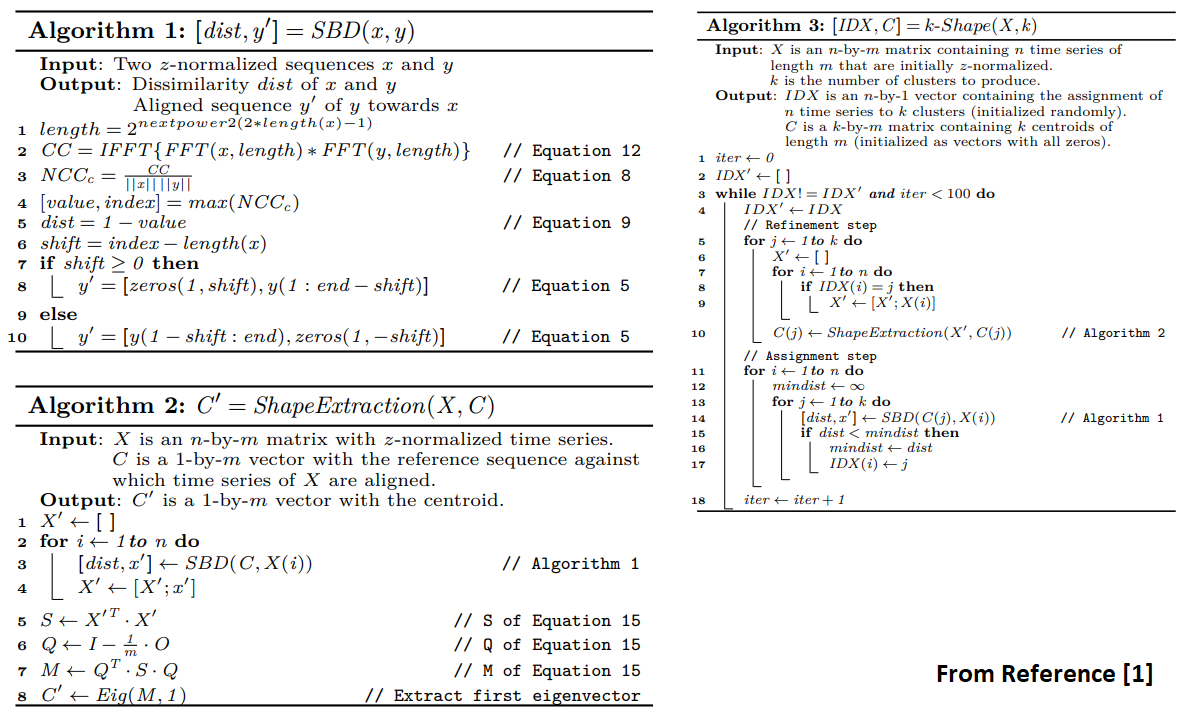

In [ ]:
!python3 -m pip install influxdb

     |████████████████████████████████| 81kB 2.5MB/s 


In [ ]:
!python3 -m pip install tslearn

     |████████████████████████████████| 798kB 4.0MB/s 


/usr/local/lib/python3.7/dist-packages/tslearn/clustering/kmeans.py:17: UserWarning: Scikit-learn <0.24 will be deprecated in a future release of tslearn
  "Scikit-learn <0.24 will be deprecated in a "
/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


maximum level is 10
maximum level is 10
(100, 240)
0.218 --> 0.207 --> 0.202 --> 0.201 --> 0.200 --> 0.200 --> 0.200 --> 


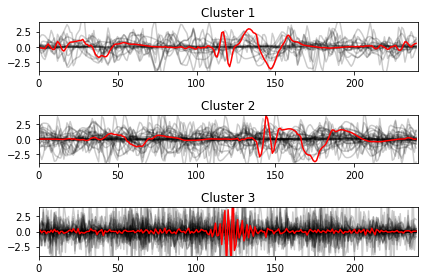

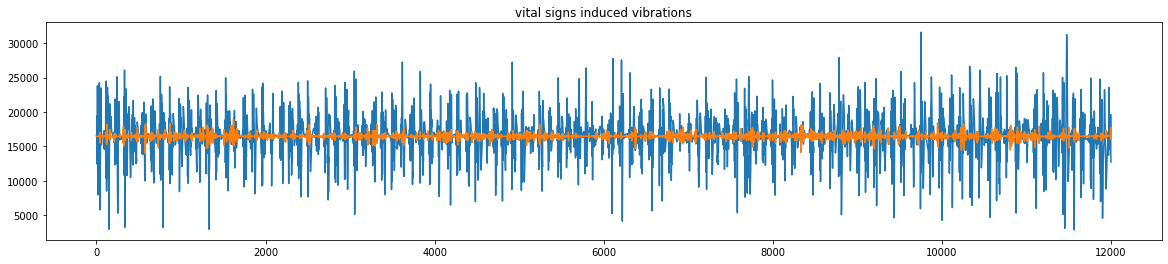

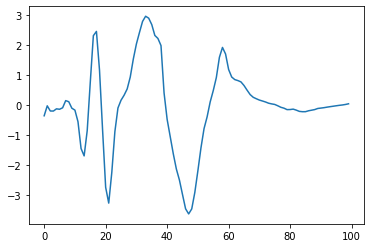

In [ ]:
#__author__ = 'Ming'
#ming.song.cn@outlook.com
#originally from http://www1.cs.columbia.edu/~jopa/Papers/PaparrizosSIGMOD2015.pdf
import numpy as np
import csv
import matplotlib.pyplot as plt
import pywt
from influxdb import InfluxDBClient
import operator
import scipy.signal as sg
import scipy as sp
# from dic.stl_decon import decomposing
from tslearn.clustering import KShape
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

def wdenoise(data, method, threshold):
    # Create wavelet object and define parameters
    w = pywt.Wavelet(method)
    maxlev = pywt.dwt_max_level(len(data), w.dec_len)
    # maxlev = 2 # Override if desired
    print("maximum level is " + str(maxlev))
    # Decompose into wavelet components, to the level selected:
    coeffs = pywt.wavedec(data, method, level=maxlev)
    #cA = 0.0
    #cA = pywt.threshold(cA, threshold*max(cA))
    # plt.figure()
    for i in range(1, len(coeffs)):
        # plt.subplot(maxlev, 1, i)
        # plt.plot(coeffs[i])
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i]))
        # plt.plot(coeffs[i])
    datarec = pywt.waverec(coeffs, method)
    return datarec

ip = "sensorweb.us"

# unit = "b8:27:eb:a1:89:49"
unit1 = "b8:27:eb:f3:41:db" #shake1 cuhk
unit2 = "b8:27:eb:ed:53:36" #shake2 cuhk
# the other one: b8:27:eb:63:da:62


stampIni = "2020-08-22T20:00:00.000Z" # UTC time = EST time + 4
stampEnd = "2020-08-22T20:02:00.000Z"

client = InfluxDBClient(ip, "8086", "test", "sensorweb", "shake", ssl=True)


# query1

query = 'SELECT "value" FROM Z WHERE ("location" = \''+unit1+'\') and time >= \''+stampIni+'\' and time <= \''+stampEnd+'\''
result = client.query(query)
points = list(result.get_points())
values = map(operator.itemgetter('value'), points)
times = map(operator.itemgetter('time'), points)

data1 = np.array(list(values))

# query2

query = 'SELECT "value" FROM Z WHERE ("location" = \''+unit2+'\') and time >= \''+stampIni+'\' and time <= \''+stampEnd+'\''
result = client.query(query)
points = list(result.get_points())
values = map(operator.itemgetter('value'), points)
times = map(operator.itemgetter('time'), points)

data2 = np.array(list(values))

fs = 100 # for vibration data



if(len(data1) == 0 or len(data2) == 0):

    print("No data in the chosen time range!")

    quit()



datarec1 = wdenoise(data1, 'sym4', 0.4)
datarec2 = wdenoise(data2, 'sym4', 0.4)

# decon = decomposing(datarec)
# exit()


#### kshape

X_train1 = np.split(datarec1, 50, axis=0)
X_train2 = np.split(datarec2, 50, axis=0)
x_train = X_train1 + X_train2
print(np.asarray(x_train).shape)
# exit()


### kshape
seed = 0
np.random.seed(seed)

np.random.shuffle(x_train)

# For this method to operate properly, prior scaling is required
x_train = TimeSeriesScalerMeanVariance().fit_transform(x_train)
sz = x_train.shape[1]

# kShape clustering
ks = KShape(n_clusters=3, verbose=True, random_state=seed)
y_pred = ks.fit_predict(x_train)

plt.figure()
for yi in range(3):
    plt.subplot(3, 1, 1 + yi)
    for xx in x_train[y_pred == yi]:
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(ks.cluster_centers_[yi].ravel(), "r-")
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.title("Cluster %d" % (yi + 1))

plt.tight_layout()
plt.show()
plt.figure(figsize=(20, 4))
plt.title("vital signs induced vibrations")

plt.plot(datarec1)
plt.plot(datarec2)
plt.show()

# plot the template
#tem = ks.cluster_centers_[0].ravel()[100:170]
tem = ks.cluster_centers_[0].ravel()[100:200]
plt.plot(tem)
plt.show()